In [1]:
#!/usr/bin/env python
# coding: utf-8

'''
sample command: python T4_BT19_ae.py -k 0 -c 0 -r 1 --data_dir /home/ruihan/data
Individual training for BioTac data (full/partial data)
if -r=1, train with full data
if -r=2, train with half data
loss = classification loss + recon loss 
'''

# Import
import os,sys
import pickle
import argparse
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from vrae.vrae import VRAEC, VRAEC_v2, VRAEC_property_layer
# c20_2: preprocess_data_copy
from preprocess_data import get_TrainValTestLoader, get_TrainValTestDataset, get_TrainValTestData, property_label
from vrae.visual import plot_grad_flow, plot_stats, tsne, multiple_tsne, tsne_show, confusion_matrix_show

def train(args):
    # Set hyper params
    args_data_dir = args.data_dir
    kfold_number = args.kfold
    data_reduction_ratio = args.reduction
    shuffle = True # set to False for partial training
    sequence_length = args.sequence_length
    number_of_features = 19

    hidden_size = args.h_s
    hidden_layer_depth = 1
    latent_length = args.latent_length
    batch_size = 200
    learning_rate = 0.001 # 0.0005
    n_epochs = 1
    dropout_rate = 0.2
    cuda = True # options: True, False
    header = None
    dataset = args.dataset
    if dataset == 'c50':
        num_class_texture = 50
    else:
        num_class_texture = 20
    if dataset == 'c20icub':
        sequence_length = 75
        number_of_features = 60
        header = 'CNN'
    
    use_stiffness = args.use_stiffness
    num_class_stiffness = 2

    use_roughness = args.use_roughness
    num_class_roughness = 2

    p_threshold = args.p_threshold

    # loss weightage
    w_r = args.w_r
    w_c = 1
    w_p_r = args.w_p_r
    w_p_s = args.w_p_s

    np.random.seed(args.rand_seed)
    torch.manual_seed(args.rand_seed)

    # Load data
    # data_dir = os.path.join(args_data_dir, "compiled_data/")
    logDir = 'models_and_stats/'
    if_plot = False

    # RNN block
    block = "LSTM" # LSTM, GRU, phased_LSTM

    model_name = 'p_in_lat_stiffness{}_roughness{}_p_thre_{}_rs_{}_B_block_{}_data_{}_wrI_{}_wC_{}_wpr_{}_wps_{}_hidden_{}_latent_{}_k_{}'.format(str(use_stiffness), str(use_roughness), str(p_threshold), str(args.rand_seed), block, dataset, w_r, w_c, w_p_r, w_p_s, str(hidden_size), str(latent_length), str(kfold_number))

    if torch.cuda.is_available() and cuda:
        device = torch.device("cuda:{}".format(args.cuda))
    else:
        device = torch.device('cpu')

    if args.reduction != 1:
        print("load {} kfold number, reduce data to {} folds, put to device: {}".format(args.kfold, args.reduction, device))
    else:
        print("load {} kfold number, train with full data, put to device: {}".format(args.kfold, device))

    prefix = ""
    dataset_dir = os.path.join(args_data_dir, dataset+"/") # TODO
    # train_set, val_set, test_set = get_TrainValTestDataset(dataset_dir, k=kfold_number, prefix=prefix, seq_len=sequence_length)
    train_loader, val_loader, test_loader = get_TrainValTestLoader(dataset_dir, k=kfold_number, batch_size=batch_size,shuffle=shuffle, prefix=prefix,seq_len=sequence_length)
    # X_train, X_val, X_test, Y_train, Y_val, Y_test = get_TrainValTestData(dataset_dir, k=kfold_number, prefix=prefix,seq_len=sequence_length)
    # Initialize models
    model = VRAEC_property_layer(num_class=num_class_texture,
                block=block,
                sequence_length=sequence_length, # TODO
                number_of_features = number_of_features,
                hidden_size = hidden_size, 
                hidden_layer_depth = hidden_layer_depth,
                latent_length = latent_length,
                batch_size = batch_size,
                learning_rate = learning_rate,
                n_epochs = n_epochs,
                dropout_rate = dropout_rate,
                cuda = cuda,
                model_name=model_name,
                header=header,
                device = device)
    model.to(device)

    # Initialize training settings
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    cl_loss_fn = nn.NLLLoss()
    recon_loss_fn = nn.MSELoss()

    # model.load_state_dict(torch.load('models_and_stats/model_phased_LSTM_B30.pt', map_location='cpu'))
    saved_dicts = torch.load(args.model_dir, map_location='cpu')
    model.load_state_dict(saved_dicts['model_state_dict'])
    optimizer.load_state_dict(saved_dicts['optimizer_state_dict'])

    training_start=datetime.now()
    # create empty lists to fill stats later
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    epoch_train_stiffness_loss = []
    epoch_train_stiffness_acc = []
    epoch_val_stiffness_loss = []
    epoch_val_stiffness_acc = []
    epoch_train_roughness_loss = []
    epoch_train_roughness_acc = []
    epoch_val_roughness_loss = []
    epoch_val_roughness_acc = []
    max_val_acc = 0
    max_val_epoch = 0

    for epoch in range(n_epochs):
        model.train()
        correct_texture = 0
        train_loss = 0
        train_num = 0
        correct_stiffness = 0
        train_stiffness_loss = 0
        correct_roughness = 0
        train_roughness_loss = 0
        
        for i, (x,  y) in enumerate(test_loader):
            x, y = x.to(device), y.long().to(device) # 32, 19, 400
            if x.size()[0] != batch_size:
                break
            
            # reduce data by data_reduction_ratio times
            if i % data_reduction_ratio == 0:
                train_num += x.size(0)
                optimizer.zero_grad()
                x_decoded, latent, output_texture, s, r = model(x)

                # assert (output == 0).nonzero().size(0)==0, 'output contain zero, batch_num'+str(i)+' indices:'+str((output == 0).nonzero())
                if (output_texture == 0).nonzero().size(0) != 0:
                    print('batch_num'+str(i)+' indices:'+str((output_texture == 0).nonzero()))
                    cl_loss = cl_loss_fn(output_texture+1e-5, y) # avoid nan
                else:
                    cl_loss = cl_loss_fn(output_texture, y) 

                stiff_y, rough_y = property_label(y)
                stiff_y, rough_y = stiff_y.type(torch.FloatTensor), rough_y.type(torch.FloatTensor)
                stiff_y, rough_y = stiff_y.to(device), rough_y.to(device)

                cl_loss_stiffness = recon_loss_fn(s, stiff_y)
                cl_loss_roughness = recon_loss_fn(r, rough_y)

                # compute classification acc
                
                correct_stiffness += torch.sum((torch.abs(s - stiff_y) < p_threshold))
                correct_roughness += torch.sum((torch.abs(r - rough_y) < p_threshold))
                # if i==0:
                #     print((torch.abs(latent[:, 0] - stiff_y) < p_threshold))
                #     print(correct_stiffness)
                # cl_loss_stiffness = cl_loss_fn(output_stiffness, stiff_y)
                # cl_loss_roughness = cl_loss_fn(output_roughness, rough_y)

                recon_loss = recon_loss_fn(x_decoded, x)
                loss = w_c * cl_loss + w_r * recon_loss
                if use_stiffness:
                    loss += w_p_s * cl_loss_stiffness
                if use_roughness:
                    loss +=  w_p_r * cl_loss_roughness
                
                # # compute classification acc
                pred_texture = output_texture.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
                correct_texture += pred_texture.eq(y.data.view_as(pred_texture)).long().cpu().sum().item()
                
                tsne_show(latent, y, p_label=stiff_y, property='stiffness')
                tsne_show(latent, y, p_label=rough_y, property='roughness')
                confusion_matrix_show(y, pred_texture)
#                 confusion_matrix_show(stiff_y, pred_stiffness)
#                 confusion_matrix_show(rough_y, pred_roughness)

In /Users/tian/opt/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/tian/opt/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/tian/opt/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/tian/opt/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/tian/o

load 4 kfold number, train with full data, put to device: cpu
chop org data of length 400 into 1 segments, each of which is has length 400
1
(600, 19, 400)


/Users/tian/opt/anaconda3/envs/AE/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/tian/Desktop/FYP/ae/code/vrae/visual.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  p_label = np.where(p_label==1, 'mid', p_label)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 9.117759
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.211555
[t-SNE] KL divergence after 300 iterations: 0.195222
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 9.117759


/Users/tian/Desktop/FYP/ae/code/vrae/visual.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  p_label = np.where(p_label==1, 'mid', p_label)


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.483307
[t-SNE] KL divergence after 300 iterations: 0.209463
showing conf matrix


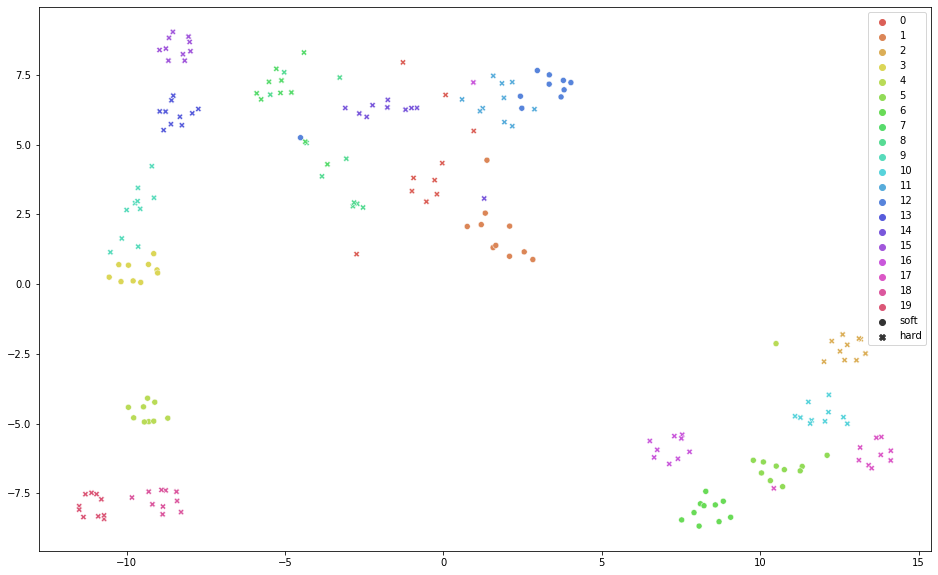

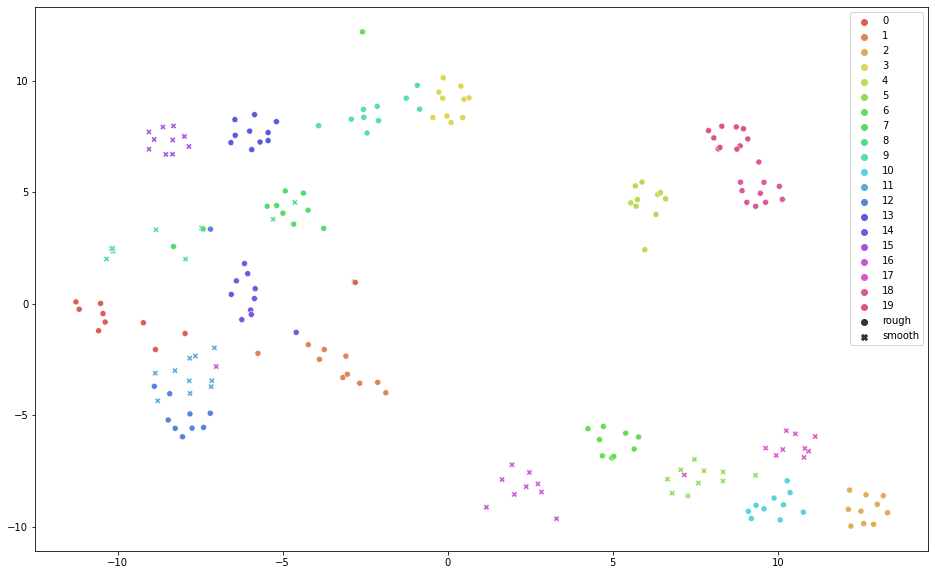

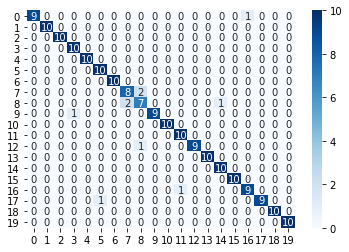

In [2]:
class Args:
    rand_seed = 1
    rep = 0
    data_dir = 'data'
    kfold = 4
    cuda = '0'
    reduction = 1
    r_on = 0.1
    p_max = 200
    w_r = 0.01
    w_p_r = 0
    w_p_s = 0
    h_s = 90
    dataset = 'c20'
    use_stiffness = 1
    use_roughness = 1 # misclassified are same in s but dif in r
    latent_length = 40
    sequence_length = 400
    p_threshold = 0.25
args=Args()   
args.model_dir = 'models_and_stats/p_in_lat_stiffness0_roughness0_data_c20_k_099.pt'


train(args)


In [3]:
import pandas as pd
def plot(file_name):
# file_name = './models_and_stats/for_plot_fold0_0.pkl'
    data = pd.read_pickle(file_name)
    fig, ax = plt.subplots(figsize=(15, 7))
    epoch_train_loss = data['epoch_train_loss']
    ax.plot(epoch_train_loss[:], label='epoch_train_loss')
    epoch_train_acc = data['epoch_train_acc']
    ax.plot(epoch_train_acc[:], label='epoch_train_acc')
    epoch_val_loss = data['epoch_val_loss']
    ax.plot(epoch_val_loss[:], label='epoch_val_loss')
    epoch_val_acc = data['epoch_val_acc']
    ax.plot(epoch_val_acc[:], label='epoch_val_acc')
    epoch_train_stiffness_acc = data['epoch_train_stiffness_acc']
    ax.plot(epoch_train_stiffness_acc[:], label='epoch_train_stiffness_acc')
    epoch_val_stiffness_acc = data['epoch_val_stiffness_acc']
    ax.plot(epoch_val_stiffness_acc[:], label='epoch_val_stiffness_acc')
    epoch_train_roughness_acc = data['epoch_train_roughness_acc']
    ax.plot(epoch_train_roughness_acc[:], label='epoch_train_roughness_acc')
    epoch_val_roughness_acc = data['epoch_val_roughness_acc']
    ax.plot(epoch_val_roughness_acc[:], label='epoch_val_roughness_acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    ax.grid(True)
    plt.legend(loc='upper right')
    # plt.savefig('save/'+'name'+'stats.png')

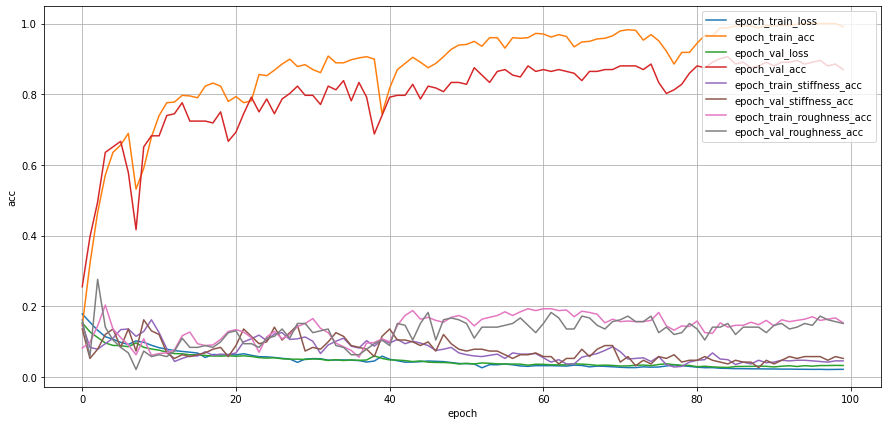

In [4]:
raec_plot_dir = 'models_and_stats/p_in_lat_stiffness0_roughness0_data_c20_k_0_stats_fold0_0.pkl'
plot(raec_plot_dir)

In [5]:
class Args:
    rand_seed = 1
    rep = 0
    data_dir = 'data'
    kfold = 4
    cuda = '0'
    reduction = 1
    r_on = 0.1
    p_max = 200
    w_r = 0.01
    w_p_r = 0
    w_p_s = 0
    h_s = 90
    dataset = 'c20'
    use_stiffness = 1
    use_roughness = 1 # misclassified are same in s but dif in r
    latent_length = 40
    sequence_length = 400
    p_threshold = 0.25
args=Args()   
args.model_dir = 'models_and_stats/p_in_lat_stiffness1_roughness1_data_c20_k_099.pt'


train(args)

load 4 kfold number, train with full data, put to device: cpu
chop org data of length 400 into 1 segments, each of which is has length 400
1
(600, 19, 400)


/Users/tian/opt/anaconda3/envs/AE/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


FileNotFoundError: [Errno 2] No such file or directory: 'models_and_stats/p_in_lat_stiffness1_roughness1_data_c20_k_099.pt'